In [316]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ParseData
import scipy.stats as stats
import numpy as np
import pytablewriter
import matplotlib
import matplotlib.patches as mpatches
import importlib
importlib.reload(ParseData)

%matplotlib notebook

Data = ParseData.GetData()

SyntaxError: invalid syntax (ParseData.py, line 165)

In [ ]:
def Doughnut(Set,Colors,ax):
    names = []
    size = []
    colors = []
    if Colors == 'Random':
        for a,s in zip(Set.index.values,Set.values):
            names.append(a+' '+str(np.round(s/np.sum(Set.values)*100,1))+'%')
            size.append(s)
            colors.append(np.random.rand(3))
    else:
        for a,s in zip(Set.index.values,Set.values):
            names.append(a+' '+str(np.round(s/np.sum(Set.values)*100,1))+'%')
            size.append(s)
            colors.append(Colors[a])
    my_circle=plt.Circle( (0,0), 0.5, facecolor='white',edgecolor='k')
    ax.pie(size, labels=names, colors=colors,wedgeprops={"edgecolor":"k"})
    ax.add_artist(my_circle)

Color_Scheme = {'Shooting':'#a6cee3','Use of Force':'#1f78b4','Other':'#b2df8a',
            'Off-Duty/Retired':'#33a02c'}

Death_Cat=Data.CA_PoliceKillings.groupby('DEATH CATEGORY').count()['NAME FIRST']
# print()
print(Data.CA_PoliceKillings.index.date.min())
# .sort_values(ascending=False)
print()
#                                                                                      )
print(Data.CA_PoliceKillings['DEATH CATEGORY'].unique())

fig,ax=plt.subplots(1,1,figsize = (6.65,4))
Doughnut(Death_Cat,Color_Scheme,ax)
ax.set_title('Police-Involved Deaths: January 2000 to April 2021 ('+str(Death_Cat.sum())+' Deaths)')

plt.savefig('Content/DeathsDistribution.png')

In [ ]:
Death_Cats = (Data.CA_PoliceKillings.groupby(['DEATH CATEGORY','RACE'])['VICTIM ID'].count().unstack())
Death_Cats['Sum'] = Death_Cats.sum(axis=1) 
print(Death_Cats['Unknown']/Death_Cats['Sum'])


In [ ]:
Missing_During = (Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
                     (Data.CA_PoliceKillings.index<'2020-07-01'))].groupby('DEATH CATEGORY')['VICTIM ID'].count())
# print(Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
#                      (Data.CA_PoliceKillings.index<'2020-07-01')#&
# #                                  (Data.CA_PoliceKillings['DEATH CATEGORY']!='Use of Force')
#                                  ),'DEATH CATEGORY'])
print(Missing_During)
print(Missing_During.sum())

Missing_After = (Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
                     (Data.CA_PoliceKillings.index>='2020-07-01'))].groupby('DEATH CATEGORY')['VICTIM ID'].count())
# print(Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')&
#                      (Data.CA_PoliceKillings.index<'2020-07-01')#&
# #                                  (Data.CA_PoliceKillings['DEATH CATEGORY']!='Use of Force')
#                                  ),'DEATH CATEGORY'])
print(Missing_After)
print(Missing_After.sum())

In [ ]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: January 1, 2000 - April 3, 2020: '+str(CA_Total.sum()))
print(Data.CA_PoliceKillings.resample('YS').count()['PROV'].max())
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']

MonthlyMiss = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force'].resample('MS').count()['PROV']
print('Missing Recrods in CBC data: ',MonthlyMiss.loc[MonthlyMiss.index<'2020-07-01'].sum())

print('Incidetns since CBC data published: ',MonthlyMiss.loc[MonthlyMiss.index>='2020-07-01'].sum())


CBC_Article = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force')
#                                           &
#                                          (Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot')
                                         )
                                        ].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings['DATA SOURCE']!='CBC Deadly Force')
#                                       &
#                                          (Data.CA_PoliceKillings['CAUSE DEATH']=='Gunshot')
                                     )
                                    ].resample('YS').count()['PROV']
print(CBC_Article.shape,
Missing.shape)
print(Missing)

LR = stats.linregress(ByYear.index.year[:-1],ByYear.values[:-1])
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police-Involved Deaths by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = np.append(CBC_Article.values,[0]),
       color=[1,0.5,0.5],edgecolor='k',label='*Missing Records*')
# ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Nov')
# ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
#         color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

<IPython.core.display.Javascript object>


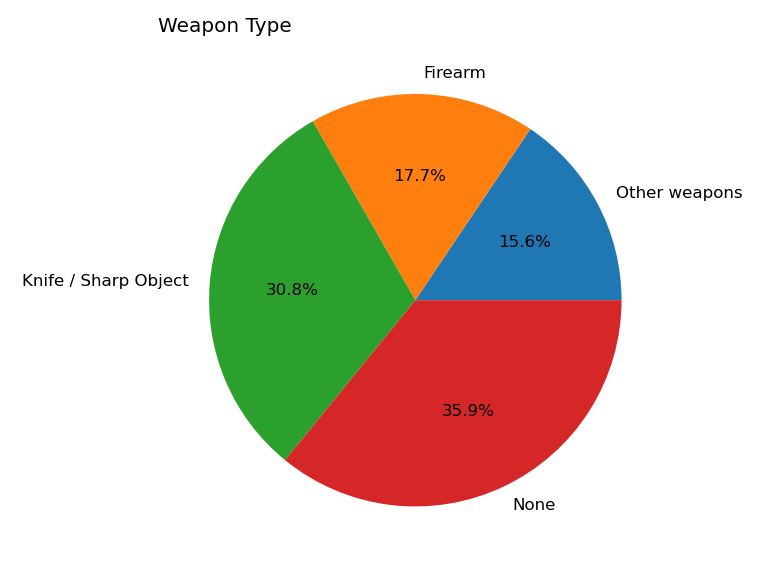

In [317]:
Weaopn_Type=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()

fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

In [318]:
Category = 'RACE'
Departments=Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV',Category]).count()['SUMMARY'].unstack()
Departments=Departments.reset_index().set_index('POLICE SERVICE')
Departments=Departments.fillna(value=0)
print(Departments.sort_values(by='Indigenous',ascending=False).head())

RACE                          PROV  Arab  Asian  Black  Indigenous  \
POLICE SERVICE                                                       
Winnipeg Police Service         MB   1.0    0.0    2.0        15.0   
RCMP                            BC   0.0    2.0    0.0        14.0   
RCMP                            AB   0.0    0.0    0.0        10.0   
Kativik Regional Police Force   QC   0.0    0.0    0.0         8.0   
RCMP                            SK   0.0    0.0    0.0         8.0   

RACE                           Latin American  Other Visible Minority  \
POLICE SERVICE                                                          
Winnipeg Police Service                   0.0                     0.0   
RCMP                                      0.0                     0.0   
RCMP                                      0.0                     0.0   
Kativik Regional Police Force             0.0                     0.0   
RCMP                                      0.0                     0.0  

In [319]:
Departments['Total'] = Departments[Data.CA_PoliceKillings[Category].unique()].sum(axis=1)

Departments['NAME']=Departments.index
Departments['NAME']=Departments['NAME'].str.replace(' Department','')
Departments['NAME']=Departments['NAME'].str.replace(' Services','')
Departments['NAME']=Departments['NAME'].str.replace(' Service','')
Departments['NAME']=Departments['NAME'].str.replace(' Force','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de la Ville de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de la sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de ','')
Departments['NAME']=Departments['NAME'].str.replace('Régie intermunicipale de police ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Sécurité publique de ','')

Departments['City']=Departments['NAME'].str.replace('Ontario Provincial Police','')
Departments['City']=Departments['City'].str.replace(' Police','')
Departments['City']=Departments['City'].str.replace('RCMP','')
Departments['City']=Departments['City'].str.replace('Sûreté du Québec','')
Departments['City']=Departments['City'].str.replace(' Regional','')
Departments['City']=Departments['City'].str.replace('Royal Newfoundland Constabulary','')
Departments['City']=Departments['City'].str.replace(' Community','')
Departments['City']=Departments['City'].str.replace('South Coast British Columbia Transit Authority','')
Departments['City']=Departments['City'].str.replace("l'agglomération de ",'')
Departments['City']=Departments['City'].str.replace('du ','')

Departments['TYPE']='Municipal/Regional'
# Departments.loc[Departments.index.str.contains('Regional')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Toronto')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains("Service de police de l'agglomération de ")==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Transit Authority Police Service')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Régie intermunicipale de police')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Service de police de la Ville de Montréal')==True,'TYPE']='Regional'
Departments.loc[Departments.index.str.contains('RCMP')==True,'TYPE']='RCMP'
Departments.loc[Departments.index.str.contains('Ontario Provincial Police')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('OPP')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Sûreté du Québec')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Royal Newfoundland Constabulary')==True,'TYPE']='Provincial'

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "Deadliest Police Departments in Canada"
writer.header_list = ['Rank',"Department", "Province", "Killings"]
TB = Departments.loc[Departments['Total']>=10].sort_values(by='Total',ascending=False).reset_index()#[0:10]
writer.value_matrix = [[index+1,value['POLICE SERVICE'],value['PROV'],value['Total']]for index,value in TB.iterrows()]
# list(Departments.groupby('TYPE').count()['NAME'])
#     ["1", "AD", "Europe/Andorra"],
#     ["2", "AE", "Asia/Dubai"],
#     ["3", "AF", "Asia/Kabul"],
#     ["4", "AG", "America/Antigua"],
#     ["5", "AI", "America/Anguilla"],
# ]
# print(Departments.head())
writer.write_table()

print(Departments['Total'].count())
print(Departments.loc[Departments['Total']>=10,'Total'].sum())
print(Departments.loc[Departments['Total']>=10,'Total'].count())

print(Departments.loc[Departments['Total']>=10,'Total'].sum()/CA_Total.sum())

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total'])

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total']/CA_Total.sum())

# print(80/CA_Total.sum())


# Deadliest Police Departments in Canada
|Rank|               Department                |Province|Killings|
|---:|-----------------------------------------|--------|-------:|
|   1|RCMP                                     |BC      |      87|
|   2|Toronto Police Service                   |ON      |      66|
|   3|RCMP                                     |AB      |      40|
|   4|Ontario Provincial Police                |ON      |      36|
|   5|Service de police de la Ville de Montréal|QC      |      35|
|   6|Sûreté du Québec                         |QC      |      34|
|   7|Edmonton Police Service                  |AB      |      31|
|   8|Calgary Police Service                   |AB      |      28|
|   9|Vancouver Police Department              |BC      |      26|
|  10|Winnipeg Police Service                  |MB      |      22|
|  11|Peel Regional Police                     |ON      |      18|
|  12|Ottawa Police Service                    |ON      |      12|
|  13|York Regional P

In [320]:
from geopy.geocoders import MapBox
import geopandas as gpd
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

geolocator = MapBox(api_key=api_key)

# print(Departments)

Departments['Lat']=np.nan
Departments['Lon']=np.nan
Departments['Geocoding_notes']=''

for index,Service in Departments.sort_values(by='Total',ascending=False).iterrows():
    try:
        if Service.TYPE=='Municipal/Regional':
            Point = geolocator.geocode(Service.NAME+', '+Service.City+', '+Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
        else:
            Point = geolocator.geocode(Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
    except:
        Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),'Geocoding_notes']='Geocoding Failed'
        pass



Departments_GPD = gpd.GeoDataFrame(Departments,
    geometry=gpd.points_from_xy(Departments.Lon,
                                Departments.Lat
                               ) )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
Departments_GPD.crs = WGS_1984
Departments_GPD = Departments_GPD.to_crs(Data.CA.crs)
print('Done')

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Done


In [321]:
print(Departments.loc[Departments['Geocoding_notes']=='Geocoding Failed'])

RACE                   PROV  Arab  Asian  Black  Indigenous  Latin American  \
POLICE SERVICE                                                                
Windsor Police Service   On   0.0    0.0    0.0         0.0             0.0   

RACE                    Other Visible Minority  South Asian  Unknown  White  \
POLICE SERVICE                                                                
Windsor Police Service                     0.0          0.0      1.0    0.0   

RACE                    Total            NAME     City                TYPE  \
POLICE SERVICE                                                               
Windsor Police Service    1.0  Windsor Police  Windsor  Municipal/Regional   

RACE                    Lat  Lon   Geocoding_notes         geometry  
POLICE SERVICE                                                       
Windsor Police Service  NaN  NaN  Geocoding Failed  POINT (nan nan)  


In [322]:
# from geopy.geocoders import MapBox
import folium
# # from IPython.display import clear_output

# api_key = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

def plot_point(Map,X,Y,Popup_Text,Color='olive',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
    folium.CircleMarker(
        # The coordiatnates
        location=[X,Y],
        # Text description
        popup=Popup_Text,
        # sets the fill color for the point
        fill_color=Color,
        # Size of the marker
        radius=Radius,
        # Opacity of the circle
        fill_opacity = Opacity,
        # Sets the line color for the edge
        color=LineColor,
        # Width of the border line
        line_weight=LineWidth,
    ).add_to(Map)

Scale,Offset=.5,1
    
Final_Map = folium.Map(
    location=[60,-91.5],
    zoom_start=3,
    tiles='Stamen Toner'
)

group0 = folium.FeatureGroup(name='RCMP')
group1 = folium.FeatureGroup(name='Provincial Police Forces')
group2 = folium.FeatureGroup(name='Municipal/Regional Police Forces')
Cats=Data.CA_PoliceKillings['RACE'].unique()
for index, row in Departments_GPD.iterrows():
    if row['Geocoding_notes'] != 'Geocoding Failed':
        
        # ''' indicates we're wrting multiline strings
        # We'll write the header and the top row of the table
        popuptext='''<body> <h2>'''+index+'''</h2> 
                    <table style="width:100%">
                    <tr>
                    <th>Race</th>
                    <th>Number of Killings &nbsp </th>
                    <th>Percentage of Total</th>
                    </tr>
                     '''
        
        # We'll sort each row by race so the largest appears at the top of the table
        Sorted = row[Cats].sort_values(ascending=False)
        for i,v in zip(Sorted.index,Sorted.values):
            if (np.isnan(v)==False) and (v>0):
                if np.isnan(v)==False:
                    # If the value for a race exists, we'll add it to the table
                    popuptext+= '''<tr>
                                <td>'''+i+''' &nbsp </td>
                                <td>'''+str(int(v))+'''</td>
                                <td>'''+str(int(v/row['Total']*100))+'''%</td>
                                </tr>'''
    #         We'll add row at the bottom of the table with the total


        popuptext+='''<tr>
                      <th>Total </th>
                      <th>'''+str(row['Total'])+'''</th>
                      <th> </th>
                      </tr>'''
        
        # We'll convert the text tot html
        test = folium.Html(popuptext, script=True)
#         folium.
        
        # This defines the parameters for the popup text box
        popup = folium.Popup(test, max_width=400,min_width=300)
        
#         # Now we can send the popup to the CircleMarker
        if row['TYPE']=='RCMP':
            plot_point(Map=group0,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#FF0000',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
            
        elif row['TYPE']=='Provincial':
            plot_point(Map=group1,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#9400D3',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
        else:
            plot_point(Map=group2,
                   X=row.Lat,#['latitude'],
                   Y=row.Lon,#['longitude'],
                   Popup_Text=popup,
                   # This is hexcode for the official red of Canada
                   Color='#0000ff',
                   # We'll scale the radius by the number of killings + 2
                   Radius=(row['Total'])*Scale+Offset,
                  )
group0.add_to(Final_Map)


group2.add_to(Final_Map)


group1.add_to(Final_Map)
    
folium.LayerControl().add_to(Final_Map)
    
Final_Map.save('Content/PoliceViolenceIncidents.html')
Final_Map

VICTIM ID         194
DATE              194
NAME FIRST        192
NAME LAST         101
NAME MIDDLE        42
NICKNAME            3
AGE               167
GENDER            194
RACE              194
PROV              194
POLICE SERVICE    194
Second              2
Third               0
CAUSE DEATH       194
DEATH CATEGORY    194
ARMED TYPE        194
DATA SOURCE       194
Link              194
SUMMARY           188
Year              194
dtype: int64
0.034096332333932486
                               0
White                   25803358
Black                    1198545
Indigenous               1673780
Unknown                        0
Latin American            447330
Other Visible Minority    364460
South Asian              1924640
Asian                    3216380
Arab                      523235


<IPython.core.display.Javascript object>


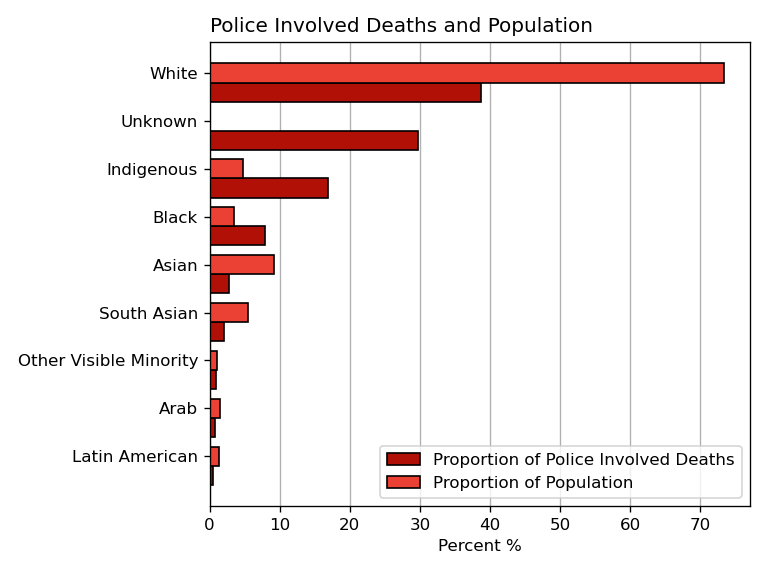

                            PROV         0
RACE                                      
Latin American          0.004587  0.012726
Arab                    0.007645  0.014885
Other Visible Minority  0.009174  0.010368
South Asian             0.019878  0.054752
Asian                   0.027523  0.091500
Black                   0.079511  0.034096
Indigenous              0.168196  0.047616
Unknown                 0.296636  0.000000
White                   0.386850  0.734057


In [323]:
print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].count())
print(Data.CA.sum()['Black']/Data.CA.sum()['Total'])

Races = (Data.CA_PoliceKillings['RACE'].unique())
Pop = Data.CA[Races].sum().to_frame()
print(Pop)


fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Police Involved Deaths and Population',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=(ByRace/ByRace.sum()).to_frame()
ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values*100,color='#b01005',edgecolor='k',
        height=.4,label='Proportion of Police Involved Deaths',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values*100,color='#eb4034',edgecolor='k',
        height=.4,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Percent %')
ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Proportional.png')


In [324]:
# ByRace = (Data.CA_PoliceKillings.groupby('RACE').count()['PROV'])
# print(ByRace['Unknown']/ByRace.sum())
Temp = Data.CBC_Data_Original

print(Temp.count()['VICTIM ID'])
print(Temp.loc[Temp['RACE']=='Unknown'].count()['VICTIM ID'])
print(Temp.loc[Temp['NAME FIRST']=='Unknown'].count()['VICTIM ID'])
print(Temp.loc[Temp['CAUSE DEATH']=='Unknown'].count()['VICTIM ID'])
print()
All = Data.CA_PoliceKillings.copy()
print(All.count()['VICTIM ID'])
print(All.loc[All['RACE']=='Unknown'].count()['VICTIM ID'])

print(All.loc[All['RACE']=='Unknown'].count()['VICTIM ID']/All.count()['VICTIM ID'])
print(All.loc[All['NAME FIRST']=='Unknown'].count()['VICTIM ID'])
print(All.loc[All['CAUSE DEATH']=='Unknown'].count()['VICTIM ID'])

print(Temp.RACE.unique())

556
136
45
22

654
194
0.2966360856269113
104
39
['Other' 'Unknown' 'White' 'Black' 'Asian' 'Indigenous' 'South Asian'
 'Arab' 'Latin American' nan]


<IPython.core.display.Javascript object>


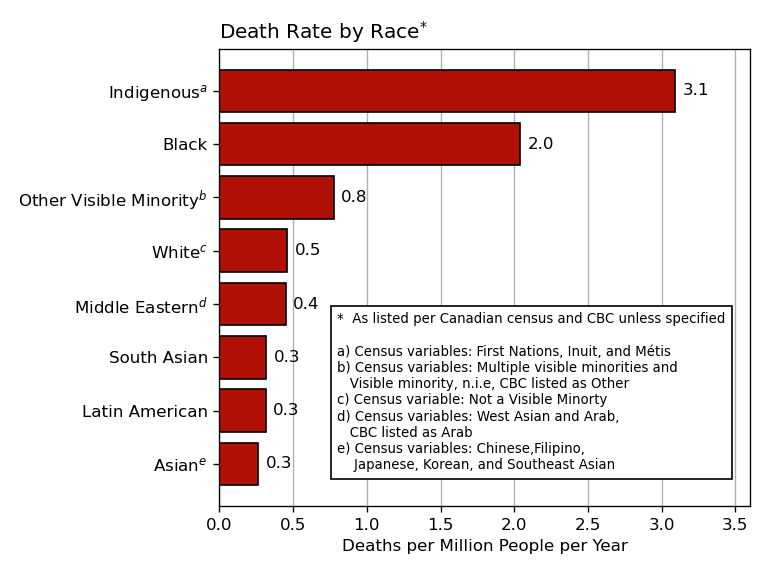

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                        PROV         0      Norm
RACE                                            
Asian                     18   3216380  0.263207
Latin American             3    447330  0.315418
South Asian               13   1924640  0.317678
Arab                       5    523235  0.449434
White                    253  25803358  0.461145
Other Visible Minority     6    364460  0.774273
Black                     52   1198545  2.040525
Indigenous               110   1673780  3.090916
['Asian' 'Latin American' 'South Asian' 'Arab' 'White'
 'Other Visible Minority' 'Black' 'Indigenous']
0.8859552265213574
654


In [326]:

Annotated_lbl = ['Asian$^{e}$', 'Latin American', 'South Asian', 'Middle Eastern$^{d}$', 'White$^{c}$',
 'Other Visible Minority$^{b}$', 'Black', 'Indigenous$^{a}$']

fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Death Rate by Race$^{*}$',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=ByRace.to_frame()
ByRace = ByRace.join(Pop,lsuffix='_Pop')
ByRace['Norm']=ByRace['PROV'].values/ByRace[0].values*1e6/Data.CA_Length
ByRace=ByRace.sort_values(by='Norm')[:-1]
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
# ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values,color='#b01005',edgecolor='k',
#         height=.4,label='Proportion of Police Killings',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace['Norm'],color='#b01005',edgecolor='k',
        height=.8,label='Proportion of Population (2016)',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(Annotated_lbl)
print(ByRace.index.values)
ax.set_xlabel('Deaths per Million People per Year')
# ax.legend()

# $^{*}$
for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .4),verticalalignment='center')
ax.set_xlim(0,3.6)

ax.annotate('Cookies',(1,1))
ax.text(.8, -.1, '*  As listed per Canadian census and CBC unless specified\n\n'+
'a) Census variables: First Nations, Inuit, and Métis\n'+
'b) Census variables: Multiple visible minorities and \n'+
'    Visible minority, n.i.e, CBC listed as Other \n'+
'c) Census variable: Not a Visible Minorty\n'+
'd) Census variables: West Asian and Arab,\n'
'   CBC listed as Arab\n'+
'e) Census variables: Chinese,Filipino, '+
'\n    Japanese, Korean, and Southeast Asian',fontsize=8, bbox=dict(facecolor='White', alpha=1))

plt.tight_layout()

plt.savefig('Content/CA_Race_Normalized.png')


print(CA_Total.sum()/Data.CA.Total.sum()/21*1e6)
# print(Data.CA.Total.sum())
print(CA_Total.sum())

In [168]:
# print(ByRace)
from scipy.stats import chisquare
# print(ByRace.index)
# R = ['Indigenous','White','Black','Arab','Asian']

R = ByRace.index.values#.drop('Unknown').values
Dept = ['Winnipeg Police Service','Vancouver Police Department','Toronto Police Service','Calgary Police Service','Edmonton Police Service']
City = ['Winnipeg','Vancouver','Toronto','Calgary','Edmonton']
FOBS = []
FEXP = []
for D,C in zip(Dept,City):
    F_obs = Departments_GPD.loc[Departments_GPD.index == D,R].values.flatten()
    F_exp = Data.Municipal_Boundaries.loc[Data.Municipal_Boundaries['Name'] == C,R].values.flatten()
    F_exp = F_exp/F_exp.sum()*Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']==D,'GENDER'].count()#F_obs.sum()
    
    FOBS.append(F_obs)
    FEXP.append(F_exp)
#     print(F_exp)
    res = chisquare(F_obs, f_exp=F_exp)
#     print(C,F_obs.sum(),res[1])

# print(Data.CA['PREABBR'])
# print(Data.CA['PREABBR'])
# Data.CA.head()
P = Departments_GPD['PROV'].unique()
# P2 = ['B.C.','B.C.']

R2 = [r+'_Killings'for r in R]
for p in P:
    try:
        F_obs = Data.CA.loc[((Data.CA.index ==  p)),
                                    R2].fillna(0).values.flatten()
        F_exp = Data.CA.loc[Data.CA.index== p,R].fillna(0).values.flatten()
        F_exp = F_exp/F_exp.sum()*F_obs.sum()
        FOBS.append(F_obs)
        FEXP.append(F_exp)
#         print(F_obs,F_exp)
        res = chisquare(F_obs, f_exp=F_exp)
#         print(p,F_obs.sum(),res[1])
        
    except:
        pass

# print('UKN',Data.CA['Unknown_Killings'].sum())

F_obs=Data.CA[R2].fillna(0).sum().values
F_exp=Data.CA[R].fillna(0).sum().values

F0 = F_exp.tolist()
print(Data.CA_PoliceKillings.count())
F0.append(F_exp.sum())
F0.append(0)
F_exp = F_exp*(Data.CA_PoliceKillings[Data.CA_PoliceKillings['RACE']!= 'Unknown'].count().RACE/F_exp.sum())

print()
res = chisquare(F_obs, f_exp=F_exp)
print(res)
R = R.tolist()
R.append('Total (Excluding Unknown)')

# R = np.append(R,'Unknown')

F1 = F_exp.tolist()
F1.append(F_exp.sum())
# F1.append(0)
F2 = F_obs.tolist()
F2.append(Data.CA_PoliceKillings[Data.CA_PoliceKillings['RACE']!= 'Unknown'].count().RACE)
# F2.append(Data.CA['Unknown_Killings'].sum())
print('F2',F2)

from tabulate import tabulate
d = {"By Race": ["Total Population (Millions)", "Expected Distribtuion", "Observed Distribution"]}
for i,r in enumerate(R):
    d[r]=[int(F0[i]/1e5)/10,int(F1[i]),int(F2[i])]
df = pd.DataFrame(d).set_index("By Race")
df = df.T.sort_values(by='Total Population (Millions)',ascending=False).T
# df.loc[df.index!='Observed Killings','Unknown']='--'


print(tabulate(df.T, tablefmt="pipe", headers="keys"))


VICTIM ID         654
DATE              654
NAME FIRST        652
NAME LAST         549
NAME MIDDLE       208
NICKNAME           31
AGE               615
GENDER            653
RACE              654
PROV              653
POLICE SERVICE    653
Second             10
Third               1
CAUSE DEATH       654
DEATH CATEGORY    654
ARMED TYPE        654
DATA SOURCE       654
Link              653
SUMMARY           644
Year              654
dtype: int64

Power_divergenceResult(statistic=474.56845269981704, pvalue=2.3439386614029363e-98)
F2 [18.0, 3.0, 13.0, 5.0, 253.0, 6.0, 52.0, 109.0, 459]
|                           |   Total Population (Millions) |   Expected Distribtuion |   Observed Distribution |
|:--------------------------|------------------------------:|------------------------:|------------------------:|
| Total (Excluding Unknown) |                          35.1 |                     459 |                     459 |
| White                     |                          25.8 |   

<IPython.core.display.Javascript object>


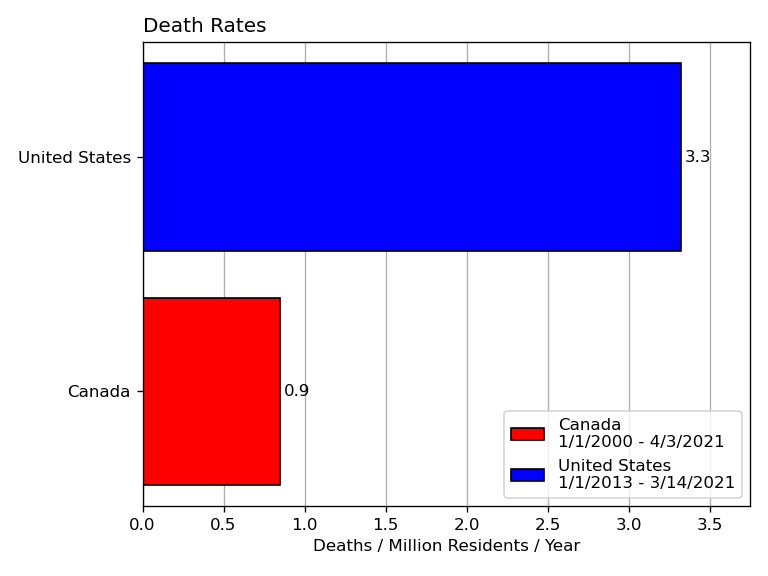

3.346965209677068 0.8736939745537109 3.8308209821256027


In [171]:
US_Total=Data.US_PoliceKillings["State"].count()
CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

fig,ax=plt.subplots()
ax.grid(axis='x')
ax.set_axisbelow(True)
# ax.grid(axis='x',zorder=0)
ax.barh([0],CA_Rate-.025,color=[1,0,0],edgecolor='k',label='Canada\n1/1/2000 - 4/3/2021')
ax.barh([1],US_Rate-.025,color=[0,0,1],edgecolor='k',label='United States\n1/1/2013 - 3/14/2021')
ax.text(CA_Rate,0,np.round(CA_Rate,1),horizontalalignment='left',verticalalignment='center')
ax.text(US_Rate,1,np.round(US_Rate,1),horizontalalignment='left',verticalalignment='center')
ax.set_yticks([0,1])
ax.set_yticklabels(['Canada','United States'])
ax.set_title('Death Rates',loc='left')
ax.set_xlabel('Deaths / Million Residents / Year')
ax.set_xlim(0,3.75)
ax.legend()


ax.legend()
plt.tight_layout()
plt.savefig('Content/NormalizedComparison.png')

print(US_Rate,CA_Rate,US_Rate/CA_Rate)

['White' 'Black' 'Indigenous' 'Unknown' 'Latin American'
 'Visible minority, n.i.e' 'South Asian' 'Asian' 'Arab']
['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total

<IPython.core.display.Javascript object>


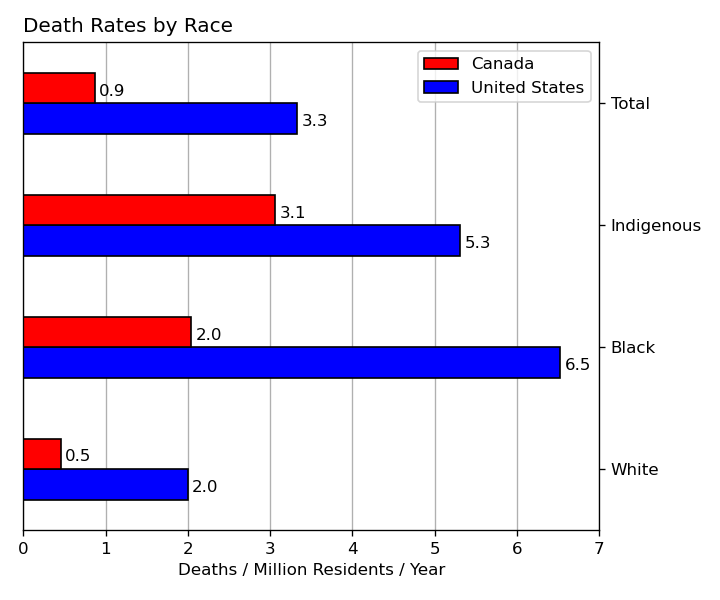

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [172]:
print(Data.CA_PoliceKillings['RACE'].unique())
# print(Data.Combined)

Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
# print(Data.Summary)
Data.Summary = Data.Summary.dropna()
Temp = Data.Summary.loc[((Data.Summary.index!='Asian'))]

fig,ax=plt.subplots(figsize=(6,5))
Temp['United States'] = Temp['US']
Temp['Canada'] = Temp['CA']
Temp[['United States','Canada']].plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder=2)
ax.set_title('Death Rates by Race',loc='left')
ax.set_xlabel('Deaths / Million Residents / Year')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .1),verticalalignment='center')

ax.set_xlim(0,7)
plt.tight_layout()
plt.savefig('Content/Racial_Comparison.png')


                  US        CA
Black       1.959811  2.342689
Indigenous  1.594882  3.516364
White       0.600761  0.529432


<IPython.core.display.Javascript object>


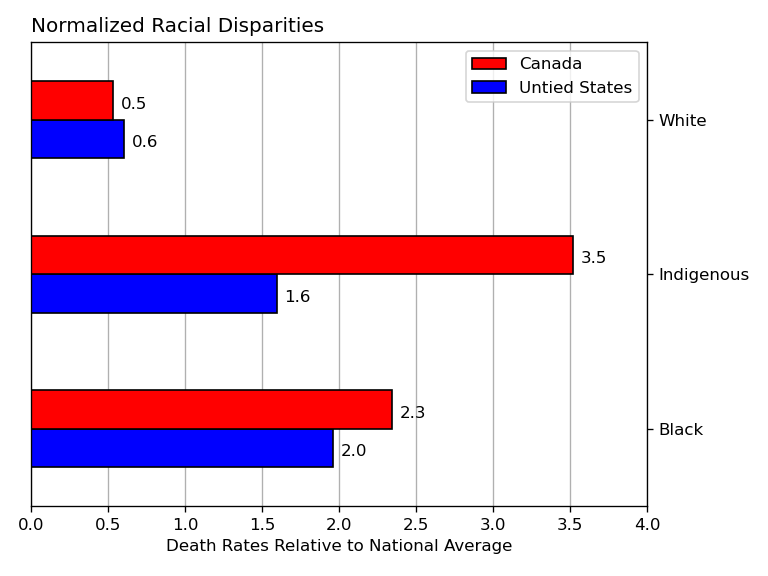

In [173]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='Total'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='Total'].values)
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='White']/Data.Summary.loc[Data.Summary.index=='Total'].values)

# Ratio *= 100
print(Ratio)
fig,ax=plt.subplots()
Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder = 2)
ax.set_title('Normalized Racial Disparities',loc='left')
ax.set_xlabel('Death Rates Relative to National Average')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], ['Canada','Untied States'])

for p in ax.patches:
    ax.annotate(str(np.round(p.get_width(),1)), (p.get_width() + .05,p.get_y() + .1),verticalalignment='center')

ax.set_xlim(0,4)
plt.tight_layout()
plt.savefig('Content/Racial_Disparities.png')


In [136]:

Data.ScaleData(scale=1e6)
Rate='Total'
Data.Breaks(column=Rate+'_Rate',classes=5,Manual_Bins=[0,1,2,5,10,15])

Data.US=Data.US.to_crs(Data.CA.crs)

['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


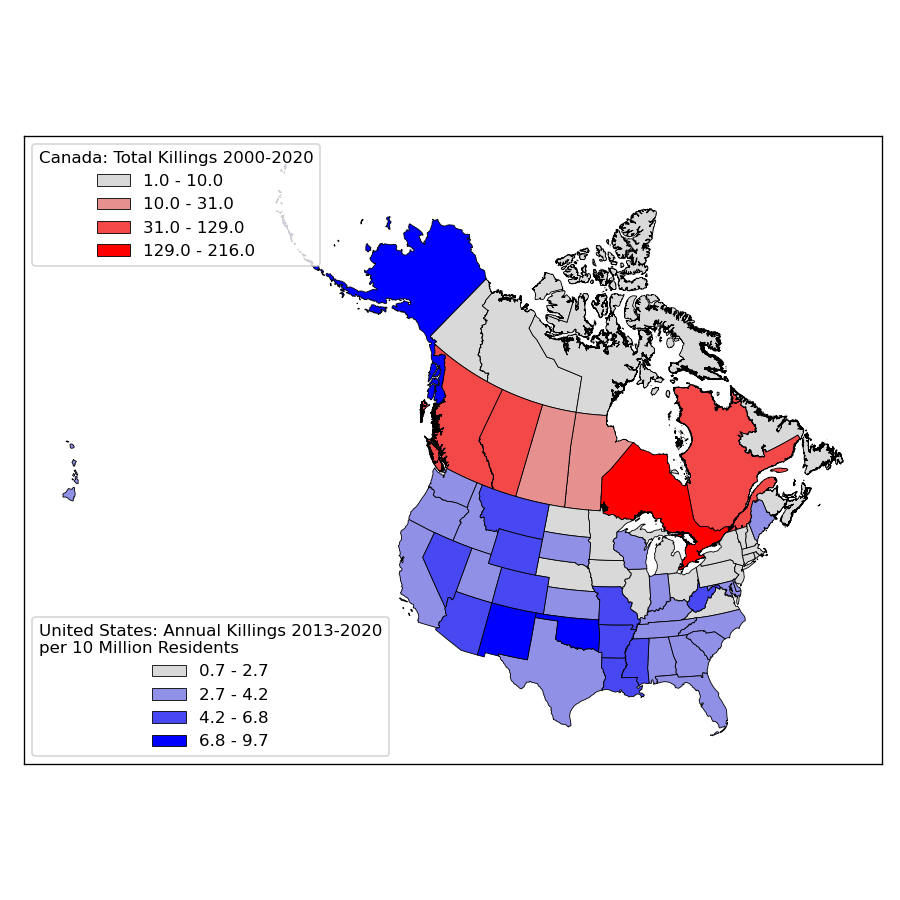

['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Legend does not support Text(0, 0, 'Canada') instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


In [174]:
Rate = 'Total'
n_classes=4

Data.ScaleData(scale=1e6)

Data.Breaks(column='Total_Killings',classes=n_classes,Manual_Bins=[1,4,7,91,175])
Data.US=Data.US.to_crs(Data.CA.crs)

labels=Data.CA[Rate+'_Killings_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = [matplotlib.text.Annotation('Canada',(0,0))]
for i,klass in enumerate(Data.CA[Rate+'_Killings_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
    if Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = []
# US_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canada: Total Killings 2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(US_Patches), loc='lower left',
      title='United States: Annual Killings 2013-2020\nper 10 Million Residents')
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title('Police Killings')

plt.tight_layout()
plt.savefig('Content/IsItNormalalized_Map.png',bbox_inches='tight')

['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['White_Killings', 'White_Rate', 'White', 'Black_Killings', 'Black_Rate', 'Black', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']
[(-0.001, 0.5], (0.5, 1.0], (1.0, 2.5], (2.5, 5.0], (5.0

<IPython.core.display.Javascript object>


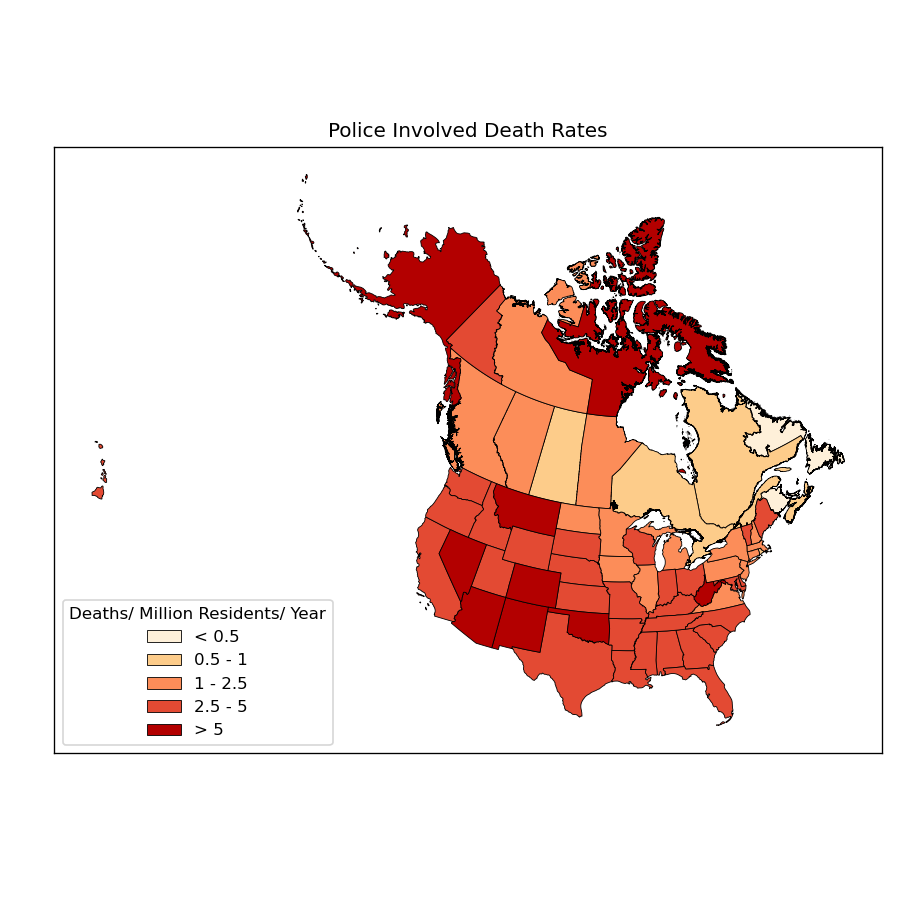

<IPython.core.display.Javascript object>


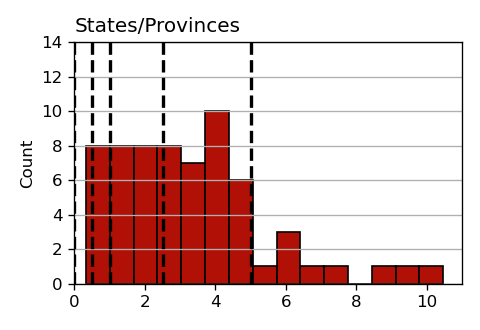

    Total_Rate  Total_Rate_MB
NL    0.361982  (-0.001, 0.5]
PE    0.329109  (-0.001, 0.5]
NB    0.440668  (-0.001, 0.5]
SK    0.984871     (0.5, 1.0]
ON    0.755393     (0.5, 1.0]
..         ...            ...
WV    5.404445    (5.0, 15.0]
NM    9.722594    (5.0, 15.0]
NU   10.467824    (5.0, 15.0]
AZ    6.804239    (5.0, 15.0]
AK    8.602333    (5.0, 15.0]

[64 rows x 2 columns]
[(-0.001, 0.5], (0.5, 1.0], (1.0, 2.5], (2.5, 5.0], (5.0, 15.0]]
Categories (5, interval[float64]): [(-0.001, 0.5] < (0.5, 1.0] < (1.0, 2.5] < (2.5, 5.0] < (5.0, 15.0]]


In [175]:

Data.ScaleData(scale=1e6)
Rate = 'Total'
n_classes=4
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,0.5,1,2.5,5,15])


labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
print(labels)

colors=['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
Combined_Color = {key:value for key,value in zip(labels,colors)}
Combined_Color = {key:value for key,value in zip(labels,colors)}

ig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()

for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
#     print(i)
    if i == 4:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':'> '+str(np.round(Data.Manual_Bins[i],1))}
    elif i == 0:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':'< '+str(np.round(Data.Manual_Bins[i+1],1))}
    else:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
#     print(Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].index)
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
#     print(Combined_Patches)
ax.legend(handles=(Combined_Patches), loc='lower left',title='Deaths/ Million Residents/ Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Police Involved Death Rates')

plt.savefig('Content/ManualBreaks_Map.png',bbox_inches='tight',dpi=500)

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in Data.Manual_Bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/ManualBreaks_Hist.png')

print(Data.Combined[[Rate+'_Rate',Rate+'_Rate_MB']].sort_values(by=Rate+'_Rate_MB'))
print(Data.Combined[Rate+'_Rate_MB'].unique().sort_values())

In [176]:
print(Data.CA.Total_Rate)

prov
NL     0.361982
PE     0.329109
NS     0.509225
NB     0.440668
QC     0.645192
ON     0.755393
MB     1.140511
SK     0.984871
AB     1.225761
BC     1.305303
YT     3.933094
NT     1.125543
NU    10.467824
Name: Total_Rate, dtype: float64


In [177]:
All = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().T
Data.CA['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.CA.loc[Data.CA.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.CA['Top'])


All = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().T
Data.US['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.US.loc[Data.US.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.US['Top'])


R = ['White','Black','Indigenous','Latin American','Hispanic','Pacific Islander']
Tempp = Data.Combined.copy()
for r in R:
    Tempp.loc[((Tempp[r]/Tempp['Total']<=.025)&(Tempp[r+'_Killings']<=2)),r+'_Rate']=np.nan
#     Tempp.loc[Tempp[r]<=5e3,r+'_Rate']=np.nan

Max = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']].max(axis=1)
Temp = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']]
# print(Temp.loc[Temp==Max])
Data.Combined['Top']=''
for index,row in Temp.iterrows():
#     print()
    Data.Combined.loc[Data.Combined.index==index,'Top']=row.loc[row==Max[index]].index.values[0].split('_')[0]
# print(Max
# print(Data.Combined['Top'])
# print(Data.Combined[['White_Rate','Black_Rate','Indigenous_Rate']])
print(Data.Combined[['Total_Rate','Pacific Islander_Rate','Black_Rate','Pacific Islander_Killings','Top']].sort_values(by='Total_Rate'))

    Total_Rate  Pacific Islander_Rate  Black_Rate  Pacific Islander_Killings  \
PE    0.329109                    NaN    0.000000                        NaN   
NL    0.361982                    NaN    0.000000                        NaN   
NB    0.440668                    NaN    0.000000                        NaN   
NS    0.509225                    NaN    0.000000                        NaN   
QC    0.645192                    NaN    1.473293                        NaN   
..         ...                    ...         ...                        ...   
AZ    6.804239                0.00000   11.969440                        NaN   
OK    7.672813               31.61285   23.747439                        1.0   
AK    8.602333               15.32973   19.366431                        1.0   
NM    9.722594                0.00000   13.241793                        NaN   
NU   10.467824                    NaN    0.000000                        NaN   

           Top  
PE       White  
NL   

['White' 'Indigenous' 'Unknown']
['Black' 'White' 'Hispanic' 'Pacific Islander']


<IPython.core.display.Javascript object>


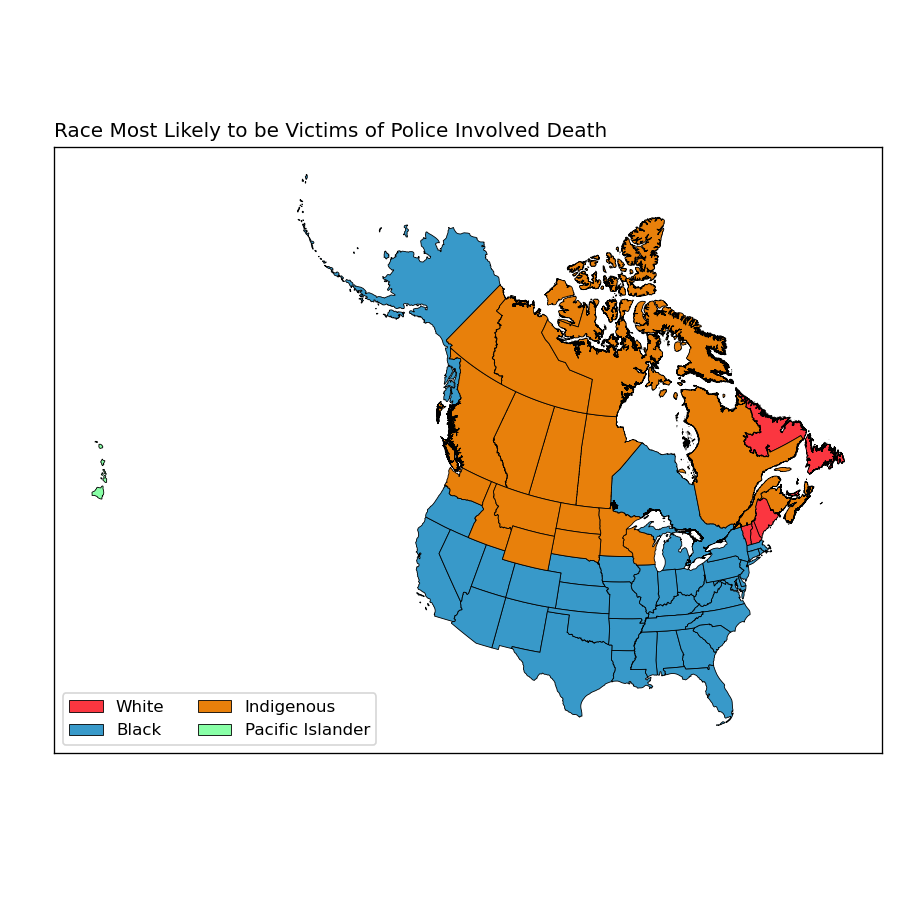

<IPython.core.display.Javascript object>


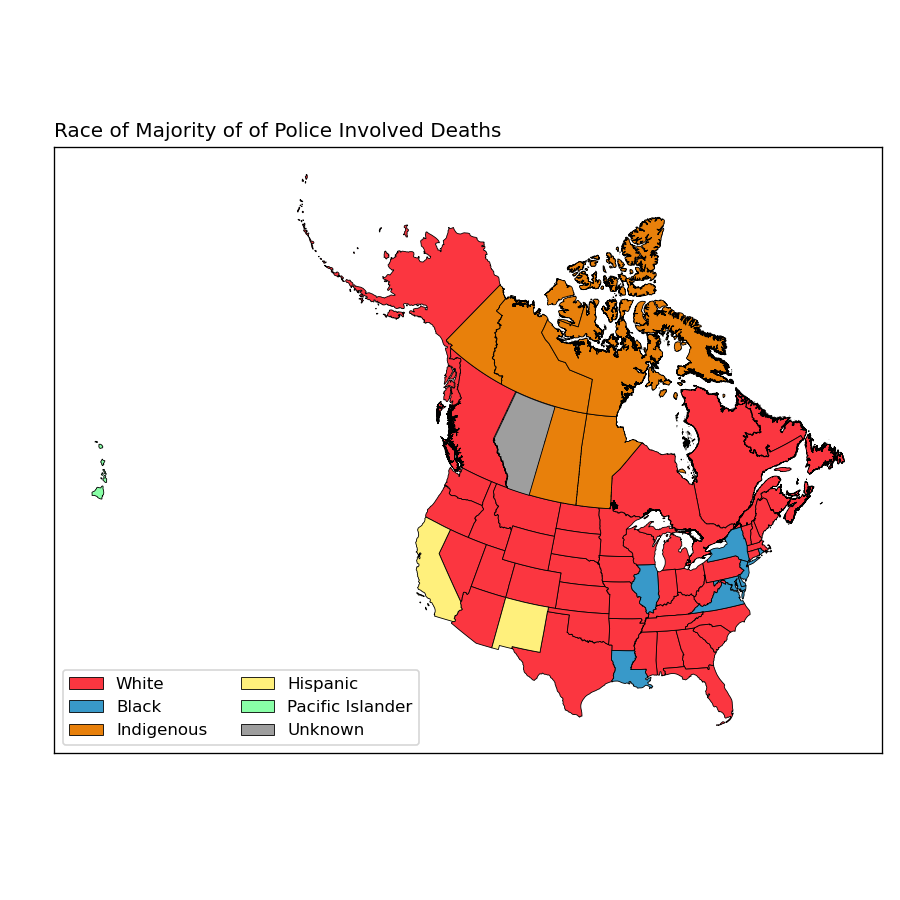

In [178]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',
            'Unknown':'#9e9e9e'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
   #str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Race Most Likely to be Victims of Police Involved Death',loc='left')

plt.savefig('Content/HighestRateRace_Map.png',bbox_inches='tight')

# RaceColor={'White':'#FB3640',
#            'Black':'#3899C9',
#            'Indigenous':'#E8800B',
#            'Hispanic':'#FFF07C',
#            'Pacific Islander':'#89FFA7'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Race of Majority of of Police Involved Deaths',loc='left')

plt.savefig('Content/MostNumerousRace_Map.png',bbox_inches='tight')


https://bccla.org/wp-content/uploads/2012/03/2012-BCCLA-Report-Police-Involved-Deaths3.pdf

['White' 'Indigenous' 'Unknown']
['Black' 'White' 'Hispanic' 'Pacific Islander']


<IPython.core.display.Javascript object>


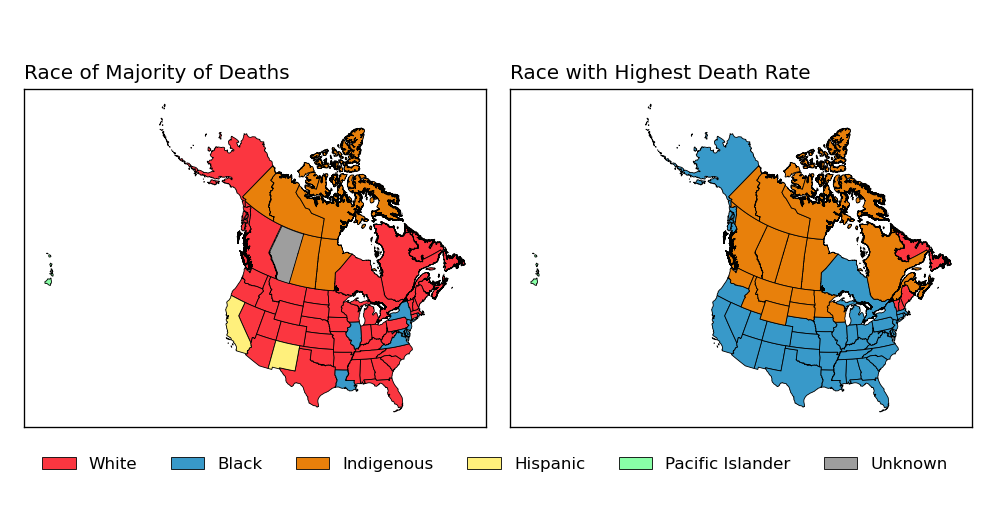

In [179]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',
            'Unknown':'#9e9e9e'}

fig,ax=plt.subplots(1,2,figsize=(8.25,4.3))

CA_Patches = []
for klass in RaceColor.keys():
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax[1],
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))
    
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Race with Highest Death Rate',loc='left')

CA_Patches = []
for klass in RaceColor.keys():
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax[0],
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax[0],
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

# ax[0].legend(handles=(CA_Patches), loc='lower left',ncol=1)
fig.legend(handles=(CA_Patches),loc='center', bbox_to_anchor= (0.5,0.1), ncol=6,
            borderaxespad=0, frameon=False)


    
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Race of Majority of Deaths',loc='left')
plt.tight_layout()

plt.savefig('Content/ImportanceOfNormalizing.png',bbox_inches='tight',dpi=500)


In [180]:
# print(Data.CA.loc[Data.CA.index=='NU',['Indigenous','Total']])
# print(30555/35944)
# Data.CA['I'] = Data.CA['Indigenous']/Data.CA['Total']
# print(Data.CA['I'].sort_values())

Data.US['I'] = Data.US['Indigenous']/Data.US['Total']
print(Data.US['I'].sort_values())
# print(Data.US.columns)

STUSPS
WV    0.001456
PA    0.001672
KY    0.001896
IN    0.002098
OH    0.002196
MD    0.002223
HI    0.002279
MA    0.002347
NJ    0.002372
VA    0.002614
NH    0.002626
CT    0.002661
DC    0.002750
VT    0.002783
FL    0.002811
IL    0.002813
TN    0.002827
GA    0.003278
IA    0.003642
RI    0.004106
NY    0.004314
MS    0.004431
AL    0.004514
MO    0.004522
DE    0.004546
SC    0.004656
TX    0.005226
MI    0.005303
LA    0.005506
ME    0.006400
AR    0.006952
CA    0.007655
WI    0.008663
KS    0.009215
NE    0.009618
CO    0.009682
MN    0.010868
UT    0.010970
NC    0.011638
OR    0.011705
WA    0.012916
ID    0.013126
NV    0.014720
WY    0.028014
AZ    0.046098
ND    0.054297
MT    0.064024
OK    0.077904
SD    0.088489
NM    0.095760
AK    0.151024
Name: I, dtype: float64
